# Veri İşleme

In [ ]:
import pandas as pd
from google.colab import files
import os

# Dosyanın var olup olmadığını kontrol edin
file_path = '/data_1.xlsx'
# Excel dosyasını yükleyin
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Convert TIME_STAMP to datetime format
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Sort the dataset by TIME_STAMP
data_sorted = data.sort_values(by='TIME_STAMP')

# Display missing values before interpolation
print("Missing values before interpolation:")
print(data_sorted.isnull().sum())

# Interpolate missing values using different methods
data_sorted['DOWNLOAD'] = data_sorted['DOWNLOAD'].interpolate(method='linear', limit_direction='both')
data_sorted['UPLOAD'] = data_sorted['UPLOAD'].interpolate(method='linear', limit_direction='both')

# Check if there are still missing values after initial interpolation
if data_sorted.isnull().sum().sum() > 0:
    data_sorted['DOWNLOAD'] = data_sorted['DOWNLOAD'].interpolate(method='polynomial', order=2, limit_direction='both')
    data_sorted['UPLOAD'] = data_sorted['UPLOAD'].interpolate(method='polynomial', order=2, limit_direction='both')

# Display missing values after interpolation
print("Missing values after interpolation:")
print(data_sorted.isnull().sum())

# Show a few rows to verify interpolation
print("Data after interpolation:")
print(data_sorted.head(20))

# Save the updated data to the same Excel file
data_sorted.to_excel(file_path, index=False, sheet_name='Sheet1')


Missing values before interpolation:
TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64
Missing values after interpolation:
TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       0
UPLOAD         0
dtype: int64
Data after interpolation:
               TIME_STAMP           SERVER_NAME   DOWNLOAD   UPLOAD
35428 2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
35427 2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
35426 2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
35425 2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
35424 2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
35423 2023-11-02 10:35:00  10.0.901.xx Server 1  14769.773  368.550
35422 2023-11-02 10:40:00  10.0.901.xx Server 1  14903.709  370.948
35421 2023-11-02 10:45:00  10.0.901.xx Server 1  15117.693  377.956
35420 2023-11-02 10:50:00  10.0.901.xx Server 1  15367.148  382.940
35419 2023-11-02 10:55:00  10.0.901.xx Server 1  15481.913 

Şimdi verideki boşlukları doldurduk devam edelim.

# Weekday

1. Veri Setini Yükleme

In [105]:
import pandas as pd
from datetime import datetime


file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Set TIME_STAMP as the index
data.set_index('TIME_STAMP', inplace=True)

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())

                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35429 entries, 2023-11-02 10:10:00 to 2024-03-05 18:25:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  35429 non-null  object 
 1   DOWNLOAD     35429 non-null  float64
 2   UPLOAD       35429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB
None


In [106]:
# Define bayram günleri (örnek olarak)
bayram_days = [
    "2024-01-01"
]
bayram_days = [datetime.strptime(day, "%Y-%m-%d").date() for day in bayram_days]

# Function to check if a date is a bayram day
def is_bayram(day):
    return day.date() in bayram_days

# Function to check if a day is weekend
def is_weekend(day):
    return day.weekday() >= 5

# Filter out weekends and bayram days
weekday_data = data[~data.index.map(is_weekend) & ~data.index.map(is_bayram)]

# Normalize the DOWNLOAD and UPLOAD columns
weekday_data.loc[:, 'DOWNLOAD_norm'] = (weekday_data['DOWNLOAD'] - weekday_data['DOWNLOAD'].mean()) / weekday_data['DOWNLOAD'].std()
weekday_data.loc[:, 'UPLOAD_norm'] = (weekday_data['UPLOAD'] - weekday_data['UPLOAD'].mean()) / weekday_data['UPLOAD'].std()


<ipython-input-106-4a0d9b4e30a8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_data.loc[:, 'DOWNLOAD_norm'] = (weekday_data['DOWNLOAD'] - weekday_data['DOWNLOAD'].mean()) / weekday_data['DOWNLOAD'].std()
<ipython-input-106-4a0d9b4e30a8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_data.loc[:, 'UPLOAD_norm'] = (weekday_data['UPLOAD'] - weekday_data['UPLOAD'].mean()) / weekday_data['UPLOAD'].std()


 Model Eğitme

In [111]:
import numpy as np
from sklearn.ensemble import IsolationForest
# Fit the Isolation Forest model with different contamination values
contamination_values = [0.3]
for contamination in contamination_values:
    print(f"Training Isolation Forest with contamination={contamination}")
    weekday_model = IsolationForest(contamination=contamination, random_state=42)
    weekday_model.fit(weekday_data[['DOWNLOAD_norm', 'UPLOAD_norm']])

    # Predict the anomaly score for the specified timestamp
    timestamp = "2024-03-05 18:25:00"
    specific_data = data.loc[timestamp]

    # Check if the specific data point is a weekday and not a bayram
    if not is_weekend(specific_data.name) and not is_bayram(specific_data.name):
        # Normalize the specific data point
        specific_data_norm_download = (specific_data['DOWNLOAD'] - weekday_data['DOWNLOAD'].mean()) / weekday_data['DOWNLOAD'].std()
        specific_data_norm_upload = (specific_data['UPLOAD'] - weekday_data['UPLOAD'].mean()) / weekday_data['UPLOAD'].std()
        specific_data_reshaped = pd.DataFrame([[specific_data_norm_download, specific_data_norm_upload]], columns=['DOWNLOAD_norm', 'UPLOAD_norm'])
        anomaly_score = weekday_model.predict(specific_data_reshaped)
    else:
        anomaly_score = None

    # Print the result
    if anomaly_score == -1:
        print(f"The data point at {timestamp} is an anomaly.")
    elif anomaly_score == 1:
        print(f"The data point at {timestamp} is normal.")
    else:
        print(f"The data point at {timestamp} could not be analyzed because it is not a valid weekday data point.")


Training Isolation Forest with contamination=0.3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


The data point at 2024-03-05 18:25:00 is an anomaly.


4. Grafik Çizimi



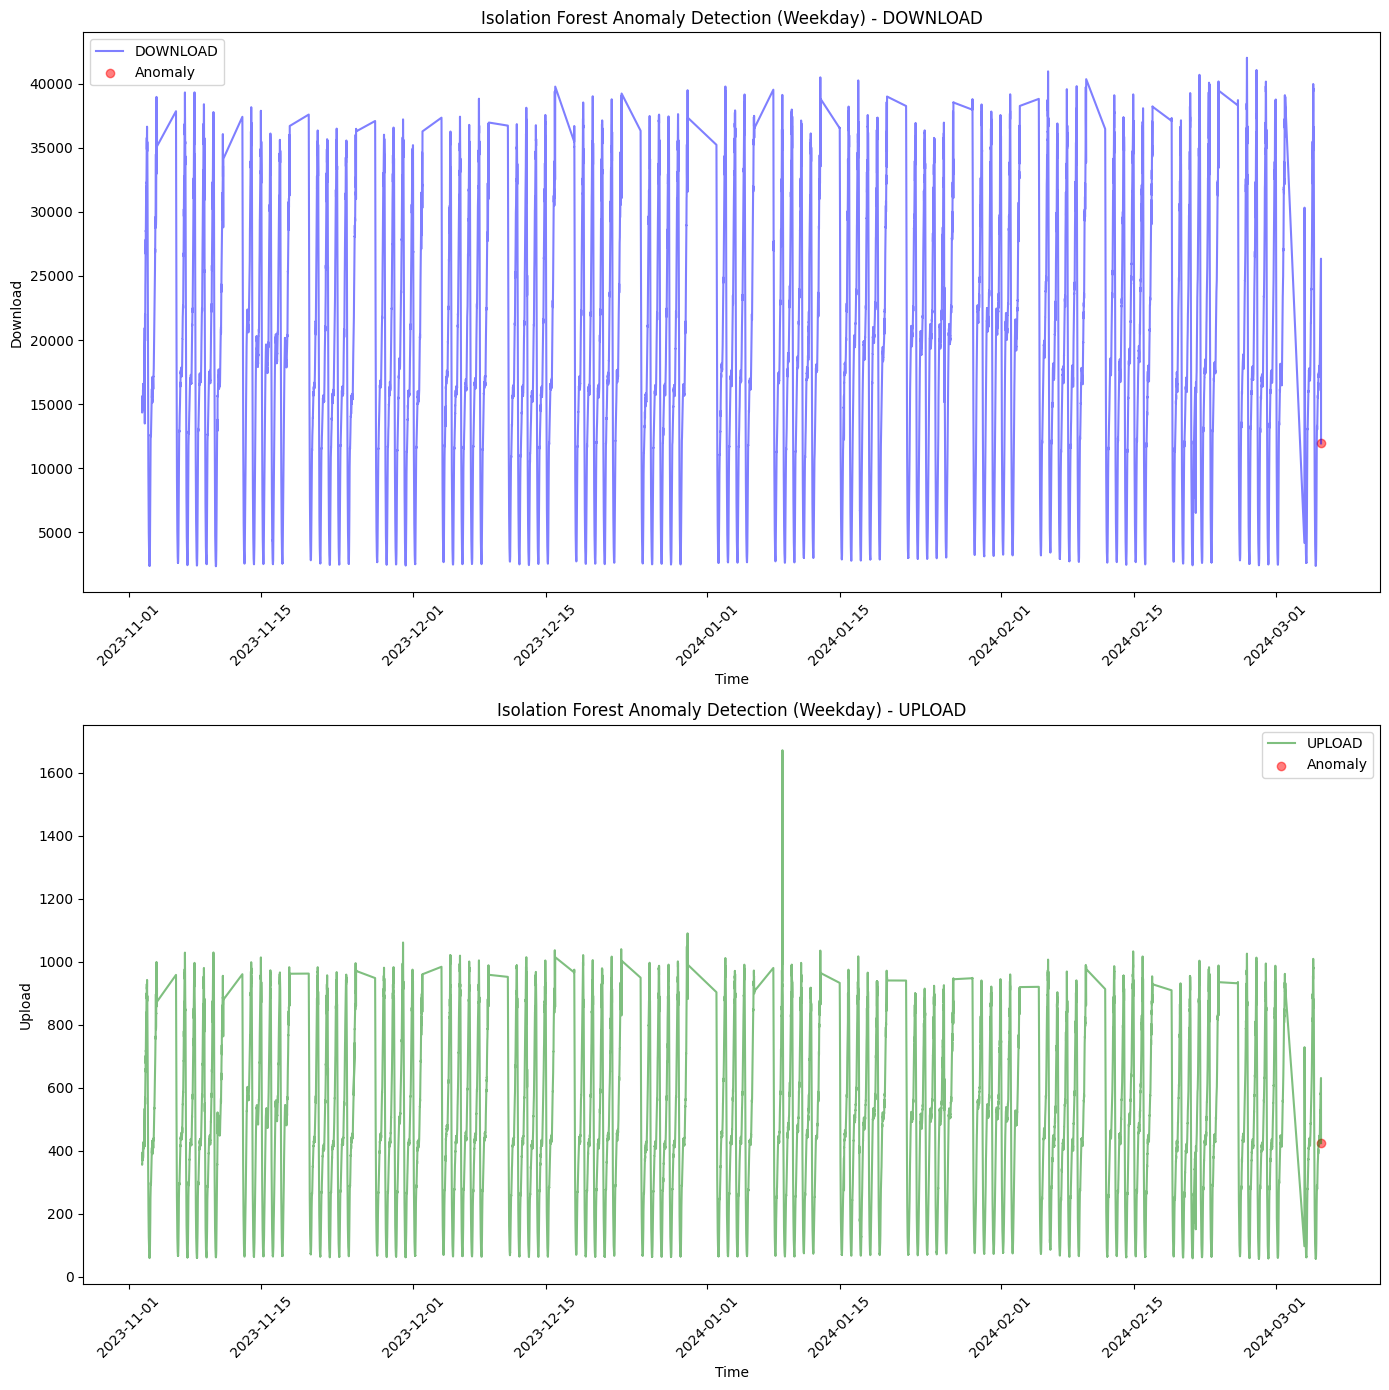

In [112]:
import matplotlib.pyplot as plt
# Visualize the anomalies for the specified timestamp

plt.figure(figsize=(14, 14))

# DOWNLOAD plot
plt.subplot(2, 1, 1)
plt.plot(weekday_data.index, weekday_data['DOWNLOAD'], label='DOWNLOAD', color='blue', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['DOWNLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Download')
plt.title('Isolation Forest Anomaly Detection (Weekday) - DOWNLOAD')
plt.legend()
plt.xticks(rotation=45)

# UPLOAD plot
plt.subplot(2, 1, 2)
plt.plot(weekday_data.index, weekday_data['UPLOAD'], label='UPLOAD', color='green', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['UPLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Upload')
plt.title('Isolation Forest Anomaly Detection (Weekday) - UPLOAD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Special Day

1. Veri Setini Yükleme ve İnceleme


In [114]:
import numpy as np
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load the processed Excel file
file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Set TIME_STAMP as the index
data.set_index('TIME_STAMP', inplace=True)

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())


                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35429 entries, 2023-11-02 10:10:00 to 2024-03-05 18:25:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  35429 non-null  object 
 1   DOWNLOAD     35429 non-null  float64
 2   UPLOAD       35429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB
None


2. Bayram Günleri ve Bayram Olmayan Günler


In [115]:
# Define bayram günleri (örnek olarak)
bayram_days = [
    "2024-01-01"
]
bayram_days = [datetime.strptime(day, "%Y-%m-%d").date() for day in bayram_days]

# Function to check if a date is a bayram day
def is_bayram(day):
    return day.date() in bayram_days

# Filter bayram and non-bayram days
bayram_data = data[data.index.map(is_bayram)]
non_bayram_data = data[~data.index.map(is_bayram)]

# Display the first few rows of the filtered data to inspect it
print(bayram_data.head())
print(bayram_data.info())

print(non_bayram_data.head())
print(non_bayram_data.info())


                              SERVER_NAME   DOWNLOAD    UPLOAD
TIME_STAMP                                                    
2024-01-01 00:00:00  10.0.901.xx Server 1  29225.862  1255.219
2024-01-01 00:05:00  10.0.901.xx Server 1  36228.341  1400.713
2024-01-01 00:15:00  10.0.901.xx Server 1  37087.196  1284.397
2024-01-01 00:20:00  10.0.901.xx Server 1  38184.749  1228.815
2024-01-01 00:25:00  10.0.901.xx Server 1  37620.287  1174.436
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2024-01-01 00:00:00 to 2024-01-01 23:55:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  285 non-null    object 
 1   DOWNLOAD     285 non-null    float64
 2   UPLOAD       285 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.9+ KB
None
                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.9

3. Verileri Normalizasyon ve Model Eğitimi


Normalizasyon

In [116]:
# Normalize the DOWNLOAD and UPLOAD columns for both bayram and non-bayram data
bayram_data.loc[:, 'DOWNLOAD_norm'] = (bayram_data['DOWNLOAD'] - bayram_data['DOWNLOAD'].mean()) / bayram_data['DOWNLOAD'].std()
bayram_data.loc[:, 'UPLOAD_norm'] = (bayram_data['UPLOAD'] - bayram_data['UPLOAD'].mean()) / bayram_data['UPLOAD'].std()

non_bayram_data.loc[:, 'DOWNLOAD_norm'] = (non_bayram_data['DOWNLOAD'] - non_bayram_data['DOWNLOAD'].mean()) / non_bayram_data['DOWNLOAD'].std()
non_bayram_data.loc[:, 'UPLOAD_norm'] = (non_bayram_data['UPLOAD'] - non_bayram_data['UPLOAD'].mean()) / non_bayram_data['UPLOAD'].std()


<ipython-input-116-1977b2311221>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayram_data.loc[:, 'DOWNLOAD_norm'] = (bayram_data['DOWNLOAD'] - bayram_data['DOWNLOAD'].mean()) / bayram_data['DOWNLOAD'].std()
<ipython-input-116-1977b2311221>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayram_data.loc[:, 'UPLOAD_norm'] = (bayram_data['UPLOAD'] - bayram_data['UPLOAD'].mean()) / bayram_data['UPLOAD'].std()
<ipython-input-116-1977b2311221>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

Model Eğitimi

In [117]:
# Fit the Isolation Forest model for bayram and non-bayram data
models = {}
for period, data_subset in zip(['Bayram', 'Non-Bayram'], [bayram_data, non_bayram_data]):
    print(f"Training Isolation Forest for {period} days")
    model = IsolationForest(contamination=0.3, random_state=42)
    model.fit(data_subset[['DOWNLOAD_norm', 'UPLOAD_norm']])
    models[period] = model


Training Isolation Forest for Bayram days


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Training Isolation Forest for Non-Bayram days


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


4. Anomali Skoru Tahmini

In [118]:
# Predict the anomaly score for the specified timestamp
timestamp = "2024-03-05 18:25:00"
specific_data = data.loc[timestamp]

# Determine if the specific date is a bayram or non-bayram day
is_bayram_day = is_bayram(specific_data.name)

# Select the appropriate model based on the date type
model_type = 'Bayram' if is_bayram_day else 'Non-Bayram'
model = models[model_type]

# Normalize the specific data point
specific_data_norm_download = (specific_data['DOWNLOAD'] - data['DOWNLOAD'].mean()) / data['DOWNLOAD'].std()
specific_data_norm_upload = (specific_data['UPLOAD'] - data['UPLOAD'].mean()) / data['UPLOAD'].std()
specific_data_reshaped = pd.DataFrame([[specific_data_norm_download, specific_data_norm_upload]], columns=['DOWNLOAD_norm', 'UPLOAD_norm'])
anomaly_score = model.predict(specific_data_reshaped)

# Print the result
if anomaly_score == -1:
    print(f"The data point at {timestamp} is an anomaly on a {model_type} day.")
elif anomaly_score == 1:
    print(f"The data point at {timestamp} is normal on a {model_type} day.")
else:
    print(f"The data point at {timestamp} could not be analyzed because it is not a valid {model_type} data point.")


The data point at 2024-03-05 18:25:00 is an anomaly on a Non-Bayram day.


5. Grafik Çizimi


5.1 Bayram Günleri İçin Grafik



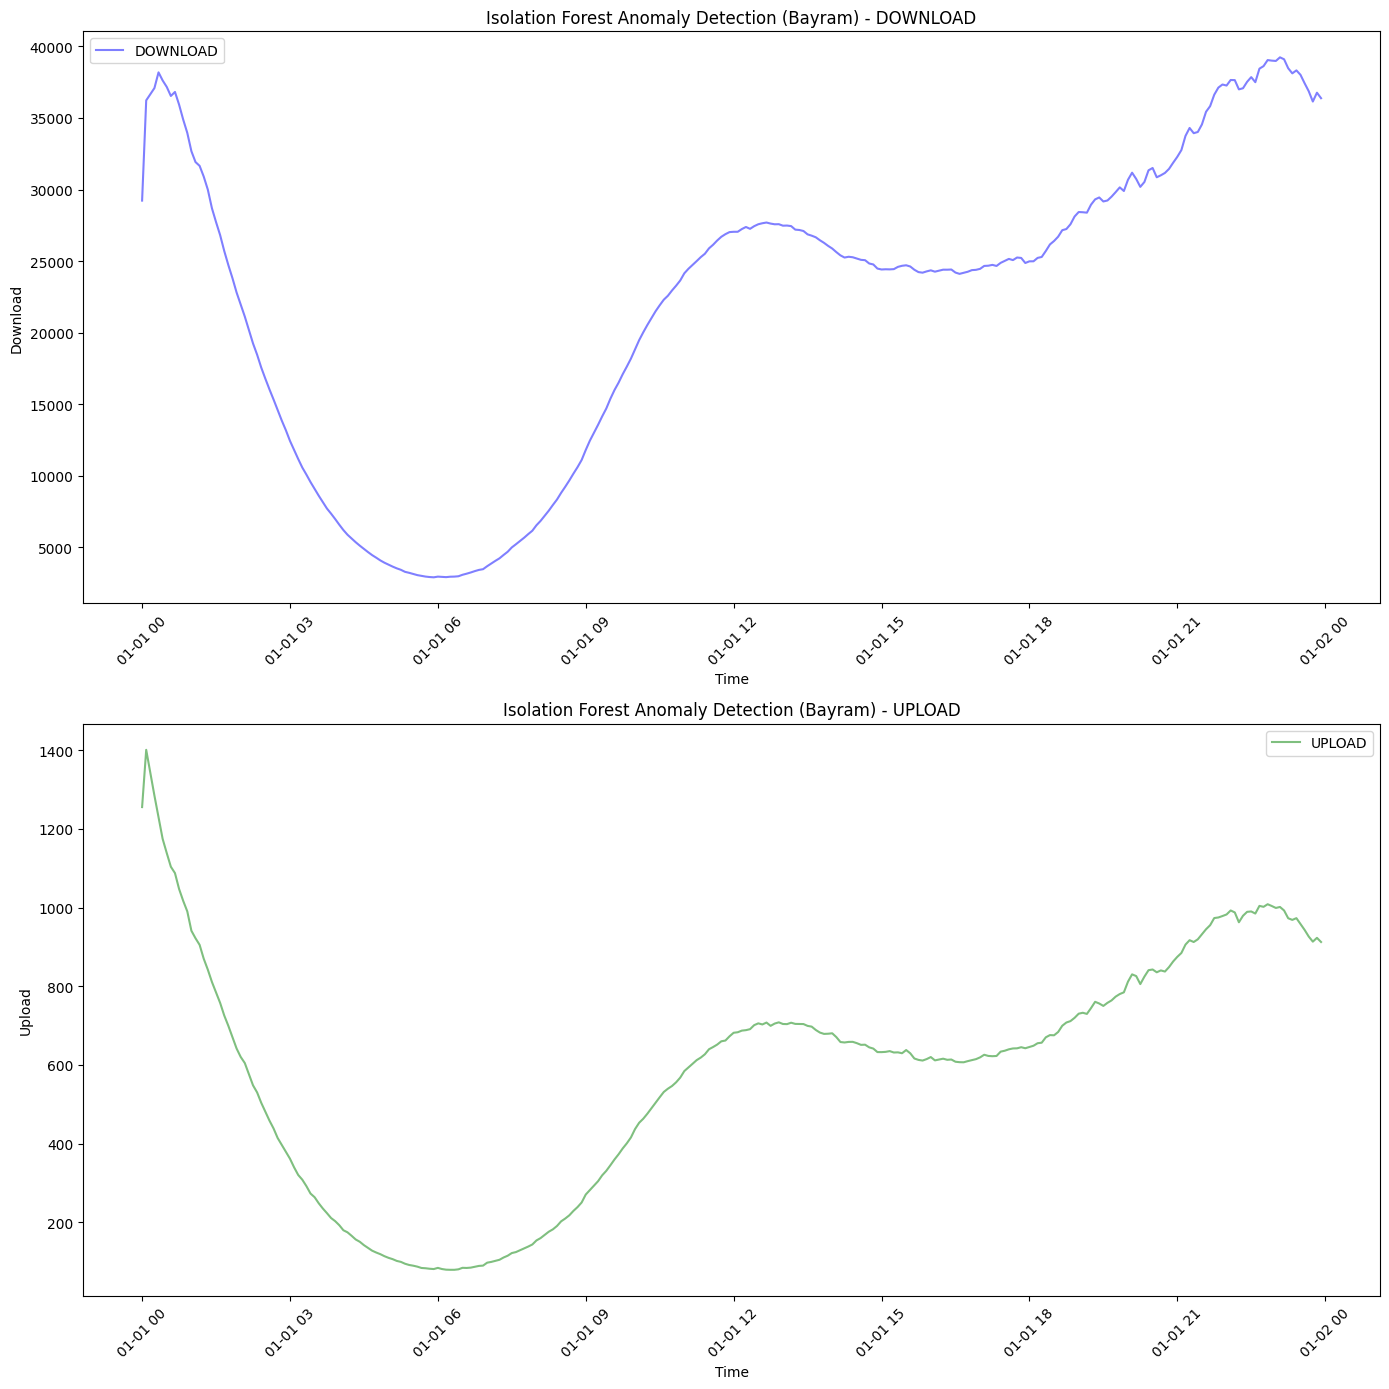

In [119]:
# Visualize the anomalies for the specified timestamp on Bayram days
plt.figure(figsize=(14, 14))

# DOWNLOAD plot for bayram data
plt.subplot(2, 1, 1)
plt.plot(bayram_data.index, bayram_data['DOWNLOAD'], label='DOWNLOAD', color='blue', alpha=0.5)
if is_bayram_day and anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['DOWNLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Download')
plt.title('Isolation Forest Anomaly Detection (Bayram) - DOWNLOAD')
plt.legend()
plt.xticks(rotation=45)

# UPLOAD plot for bayram data
plt.subplot(2, 1, 2)
plt.plot(bayram_data.index, bayram_data['UPLOAD'], label='UPLOAD', color='green', alpha=0.5)
if is_bayram_day and anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['UPLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Upload')
plt.title('Isolation Forest Anomaly Detection (Bayram) - UPLOAD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


5.2 Bayram Olmayan Günler İçin Grafik



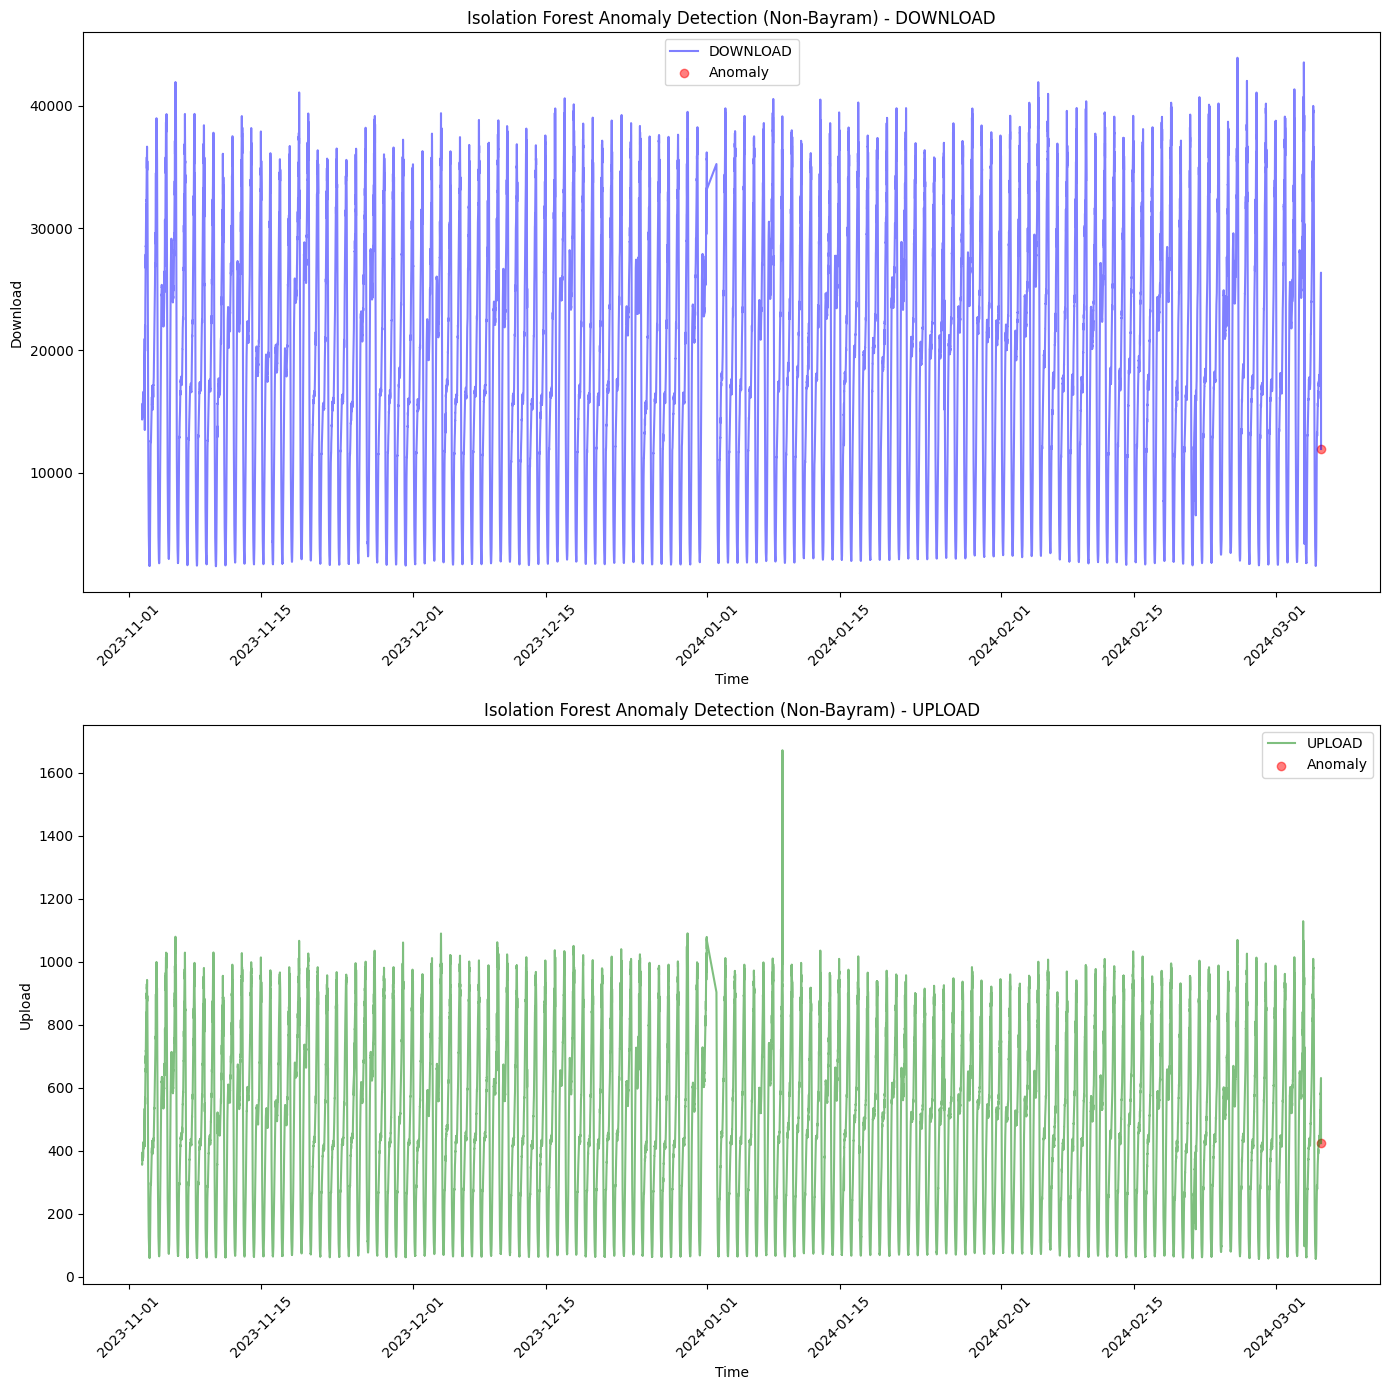

In [120]:
# Visualize the anomalies for the specified timestamp on Non-Bayram days
plt.figure(figsize=(14, 14))

# DOWNLOAD plot for non-bayram data
plt.subplot(2, 1, 1)
plt.plot(non_bayram_data.index, non_bayram_data['DOWNLOAD'], label='DOWNLOAD', color='blue', alpha=0.5)
if not is_bayram_day and anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['DOWNLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Download')
plt.title('Isolation Forest Anomaly Detection (Non-Bayram) - DOWNLOAD')
plt.legend()
plt.xticks(rotation=45)

# UPLOAD plot for non-bayram data
plt.subplot(2, 1, 2)
plt.plot(non_bayram_data.index, non_bayram_data['UPLOAD'], label='UPLOAD', color='green', alpha=0.5)
if not is_bayram_day and anomaly_score == -1:
    plt.scatter(specific_data.name, specific_data['UPLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Upload')
plt.title('Isolation Forest Anomaly Detection (Non-Bayram) - UPLOAD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#  HOUR

1. Veri Setini Yükleme ve İnceleme

In [121]:
import numpy as np
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load the processed Excel file
file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Set TIME_STAMP as the index
data.set_index('TIME_STAMP', inplace=True)

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())


                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35429 entries, 2023-11-02 10:10:00 to 2024-03-05 18:25:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  35429 non-null  object 
 1   DOWNLOAD     35429 non-null  float64
 2   UPLOAD       35429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB
None


2. Saatlik Veri Gruplama

In [122]:
# Extract hour from TIME_STAMP
data['HOUR'] = data.index.hour

# Select only numeric columns for calculating the mean
numeric_columns = data.select_dtypes(include=np.number).columns
hourly_data = data[numeric_columns].groupby('HOUR').mean()

# Display the first few rows of the hourly grouped data to inspect it
print(hourly_data.head())
print(hourly_data.info())

          DOWNLOAD      UPLOAD
HOUR                          
0     30503.295930  766.468710
1     19418.344192  480.727825
2     10502.802042  261.519166
3      5691.739048  143.201510
4      3440.368907   87.106335
<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DOWNLOAD  24 non-null     float64
 1   UPLOAD    24 non-null     float64
dtypes: float64(2)
memory usage: 480.0 bytes
None


3. Verileri Normalizasyon ve Model Eğitimi

3.1 Normalizasyon

In [123]:
# Normalize the DOWNLOAD and UPLOAD columns for hourly data
hourly_data['DOWNLOAD_norm'] = (hourly_data['DOWNLOAD'] - hourly_data['DOWNLOAD'].mean()) / hourly_data['DOWNLOAD'].std()
hourly_data['UPLOAD_norm'] = (hourly_data['UPLOAD'] - hourly_data['UPLOAD'].mean()) / hourly_data['UPLOAD'].std()


3.2 Model Eğitimi

In [135]:
# Fit the Isolation Forest model for hourly data
print("Training Isolation Forest for hourly data")
hourly_model = IsolationForest(contamination=0.05, random_state=42)
hourly_model.fit(hourly_data[['DOWNLOAD_norm', 'UPLOAD_norm']])


Training Isolation Forest for hourly data


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

4. Anomali Skoru Tahmini



In [136]:
# Predict the anomaly score for the specified timestamp
timestamp = "2024-03-05 18:25:00"
specific_data = data.loc[timestamp]

# Extract hour from the specific timestamp
specific_hour = specific_data.name.hour

# Get the corresponding hourly data
specific_hour_data = hourly_data.loc[specific_hour]

# Normalize the specific data point
specific_data_norm_download = (specific_data['DOWNLOAD'] - data['DOWNLOAD'].mean()) / data['DOWNLOAD'].std()
specific_data_norm_upload = (specific_data['UPLOAD'] - data['UPLOAD'].mean()) / data['UPLOAD'].std()
specific_data_reshaped = pd.DataFrame([[specific_data_norm_download, specific_data_norm_upload]], columns=['DOWNLOAD_norm', 'UPLOAD_norm'])
anomaly_score = hourly_model.predict(specific_data_reshaped)

# Print the result
if anomaly_score == -1:
    print(f"The data point at {timestamp} is an anomaly at hour {specific_hour}.")
elif anomaly_score == 1:
    print(f"The data point at {timestamp} is normal at hour {specific_hour}.")
else:
    print(f"The data point at {timestamp} could not be analyzed because it is not a valid hourly data point.")


The data point at 2024-03-05 18:25:00 is normal at hour 18.


5. Grafik Çizimi

5.1 Saatlik Veriler İçin Grafik

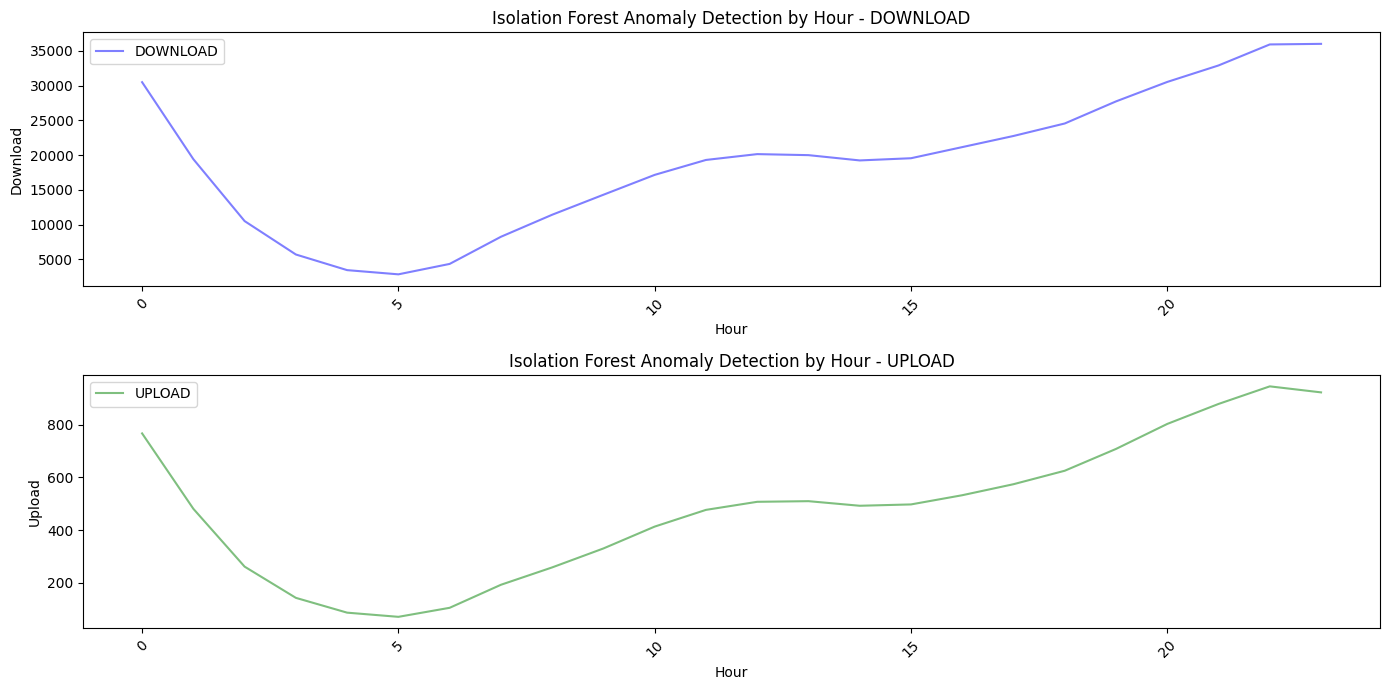

In [137]:
# Visualize the anomalies for the specified timestamp by hour
plt.figure(figsize=(14, 7))

# DOWNLOAD plot for hourly data
plt.subplot(2, 1, 1)
plt.plot(hourly_data.index, hourly_data['DOWNLOAD'], label='DOWNLOAD', color='blue', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_hour, specific_data['DOWNLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('Download')
plt.title('Isolation Forest Anomaly Detection by Hour - DOWNLOAD')
plt.legend()
plt.xticks(rotation=45)

# UPLOAD plot for hourly data
plt.subplot(2, 1, 2)
plt.plot(hourly_data.index, hourly_data['UPLOAD'], label='UPLOAD', color='green', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_hour, specific_data['UPLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('Upload')
plt.title('Isolation Forest Anomaly Detection by Hour - UPLOAD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# MINUTE

1. Veri Setini Yükleme ve İnceleme



In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load the processed Excel file
file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Set TIME_STAMP as the index
data.set_index('TIME_STAMP', inplace=True)

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())


                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35429 entries, 2023-11-02 10:10:00 to 2024-03-05 18:25:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  35429 non-null  object 
 1   DOWNLOAD     35429 non-null  float64
 2   UPLOAD       35429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB
None


2. Dakikalık Veri Gruplama

In [ ]:
# Extract minute from TIME_STAMP
data['MINUTE'] = data.index.minute

# Select only numeric columns for the mean calculation
numeric_data = data.select_dtypes(include=np.number)

# Group numeric data by minute and calculate the mean
minute_data = numeric_data.groupby('MINUTE').mean()

# Display the first few rows of the minute grouped data to inspect it
print(minute_data.head())
print(minute_data.info())

            DOWNLOAD      UPLOAD
MINUTE                          
0       19113.866706  486.210064
5       19135.937064  484.934128
10      18728.316097  475.595401
15      19021.772975  481.791409
20      19002.312945  481.001731
<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 55
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DOWNLOAD  12 non-null     float64
 1   UPLOAD    12 non-null     float64
dtypes: float64(2)
memory usage: 240.0 bytes
None


3. Verileri Normalizasyon ve Model Eğitimi



3.1 Normalizasyon


In [ ]:
# Normalize the DOWNLOAD and UPLOAD columns for minute data
minute_data['DOWNLOAD_norm'] = (minute_data['DOWNLOAD'] - minute_data['DOWNLOAD'].mean()) / minute_data['DOWNLOAD'].std()
minute_data['UPLOAD_norm'] = (minute_data['UPLOAD'] - minute_data['UPLOAD'].mean()) / minute_data['UPLOAD'].std()


3.2 Model Eğitimi


In [141]:
# Fit the Isolation Forest model for minute data
print("Training Isolation Forest for minute data")
minute_model = IsolationForest(contamination=0.05, random_state=42)
minute_model.fit(minute_data[['DOWNLOAD_norm', 'UPLOAD_norm']])


Training Isolation Forest for minute data


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

4. Anomali Skoru Tahmini



In [142]:
# Predict the anomaly score for the specified timestamp
timestamp = "2024-03-05 18:25:00"
specific_data = data.loc[timestamp]

# Extract minute from the specific timestamp
specific_minute = specific_data.name.minute

# Get the corresponding minute data
specific_minute_data = minute_data.loc[specific_minute]

# Normalize the specific data point
specific_data_norm_download = (specific_data['DOWNLOAD'] - data['DOWNLOAD'].mean()) / data['DOWNLOAD'].std()
specific_data_norm_upload = (specific_data['UPLOAD'] - data['UPLOAD'].mean()) / data['UPLOAD'].std()
specific_data_reshaped = pd.DataFrame([[specific_data_norm_download, specific_data_norm_upload]], columns=['DOWNLOAD_norm', 'UPLOAD_norm'])
anomaly_score = minute_model.predict(specific_data_reshaped)

# Print the result
if anomaly_score == -1:
    print(f"The data point at {timestamp} is an anomaly at minute {specific_minute}.")
elif anomaly_score == 1:
    print(f"The data point at {timestamp} is normal at minute {specific_minute}.")
else:
    print(f"The data point at {timestamp} could not be analyzed because it is not a valid minute data point.")


The data point at 2024-03-05 18:25:00 is normal at minute 25.


5. Grafik Çizimi



5.1 Dakikalık Veriler İçin Grafik


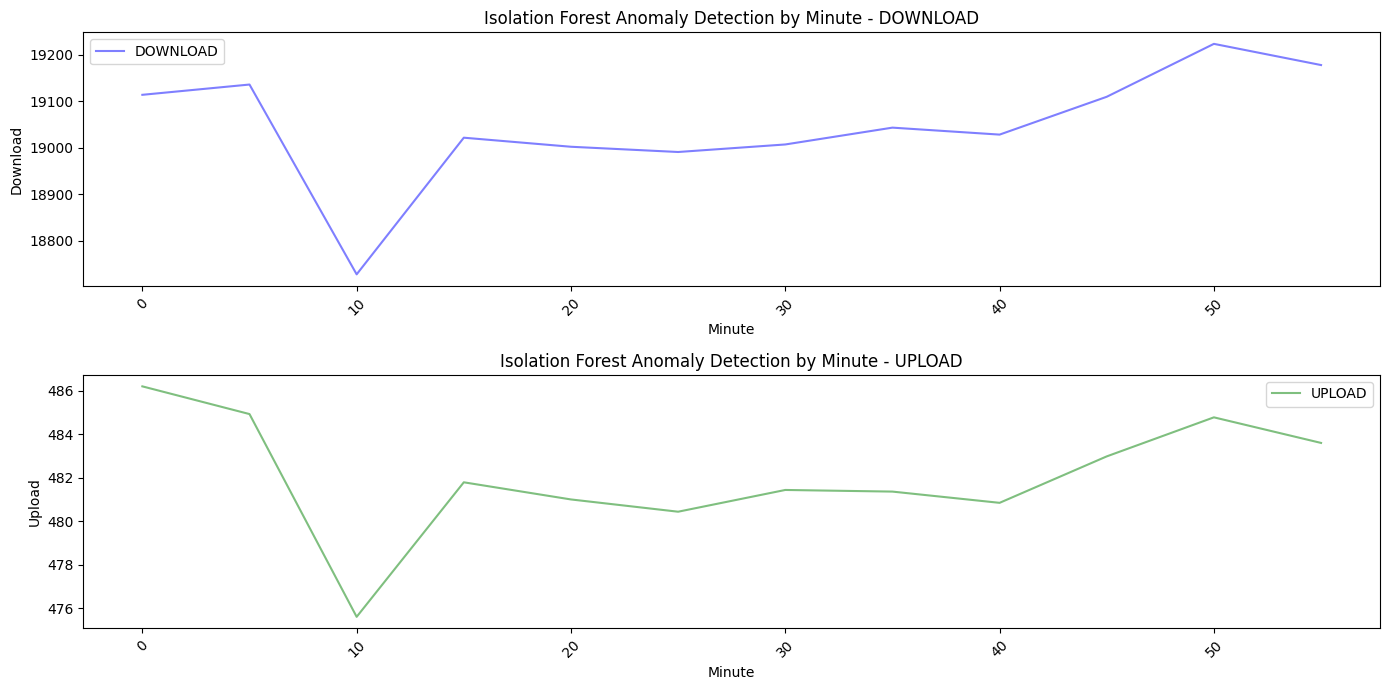

In [143]:
# Visualize the anomalies for the specified timestamp by minute
plt.figure(figsize=(14, 7))

# DOWNLOAD plot for minute data
plt.subplot(2, 1, 1)
plt.plot(minute_data.index, minute_data['DOWNLOAD'], label='DOWNLOAD', color='blue', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_minute, specific_data['DOWNLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Minute')
plt.ylabel('Download')
plt.title('Isolation Forest Anomaly Detection by Minute - DOWNLOAD')
plt.legend()
plt.xticks(rotation=45)

# UPLOAD plot for minute data
plt.subplot(2, 1, 2)
plt.plot(minute_data.index, minute_data['UPLOAD'], label='UPLOAD', color='green', alpha=0.5)
if anomaly_score == -1:
    plt.scatter(specific_minute, specific_data['UPLOAD'], color='red', label='Anomaly', alpha=0.5)
plt.xlabel('Minute')
plt.ylabel('Upload')
plt.title('Isolation Forest Anomaly Detection by Minute - UPLOAD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Time Series Forecasting (LSTM)

1. Veri Setini Yükleme ve İşleme

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the updated Excel file
file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Set TIME_STAMP as the index
data.set_index('TIME_STAMP', inplace=True)

# Sort the data by TIME_STAMP
data.sort_index(inplace=True)

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())


                              SERVER_NAME   DOWNLOAD   UPLOAD
TIME_STAMP                                                   
2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395
2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811
2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816
2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717
2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35429 entries, 2023-11-02 10:10:00 to 2024-03-05 18:25:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SERVER_NAME  35429 non-null  object 
 1   DOWNLOAD     35429 non-null  float64
 2   UPLOAD       35429 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB
None


2. DOWNLOAD ve UPLOAD Verilerini Normalize Etme



In [ ]:
# Normalize the data
scaler_download = MinMaxScaler(feature_range=(0, 1))
data['DOWNLOAD'] = scaler_download.fit_transform(data[['DOWNLOAD']])

scaler_upload = MinMaxScaler(feature_range=(0, 1))
data['UPLOAD'] = scaler_upload.fit_transform(data[['UPLOAD']])


3. LSTM Modeli için Veri Seti Oluşturma



In [ ]:
# Create the dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10

# DOWNLOAD için
X_download, Y_download = create_dataset(data[['DOWNLOAD']].values, time_step)
X_download = X_download.reshape(X_download.shape[0], X_download.shape[1], 1)

# UPLOAD için
X_upload, Y_upload = create_dataset(data[['UPLOAD']].values, time_step)
X_upload = X_upload.reshape(X_upload.shape[0], X_upload.shape[1], 1)


4. LSTM Modelini Oluşturma ve Eğitme



4.1 DOWNLOAD İçin Model


In [ ]:
# Create the LSTM model for DOWNLOAD
model_download = Sequential()
model_download.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_download.add(LSTM(50, return_sequences=False))
model_download.add(Dense(1))
model_download.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_download.fit(X_download, Y_download, epochs=20, batch_size=64, verbose=1)

# Make predictions
train_predict_download = model_download.predict(X_download)

# Inverse transform the predictions
train_predict_download = scaler_download.inverse_transform(train_predict_download)
Y_download = scaler_download.inverse_transform([Y_download])


Epoch 1/20
554/554 [==============================] - 17s 19ms/step - loss: 0.0038
Epoch 2/20
554/554 [==============================] - 10s 19ms/step - loss: 5.0708e-04
Epoch 3/20
554/554 [==============================] - 11s 21ms/step - loss: 3.7032e-04
Epoch 4/20
554/554 [==============================] - 14s 25ms/step - loss: 3.1312e-04
Epoch 5/20
554/554 [==============================] - 13s 23ms/step - loss: 2.6688e-04
Epoch 6/20
554/554 [==============================] - 11s 19ms/step - loss: 2.3450e-04
Epoch 7/20
554/554 [==============================] - 9s 17ms/step - loss: 2.1035e-04
Epoch 8/20
554/554 [==============================] - 13s 24ms/step - loss: 1.8793e-04
Epoch 9/20
554/554 [==============================] - 11s 21ms/step - loss: 1.6976e-04
Epoch 10/20
554/554 [==============================] - 11s 19ms/step - loss: 1.6220e-04
Epoch 11/20
554/554 [==============================] - 10s 19ms/step - loss: 1.6996e-04
Epoch 12/20
554/554 [=========================

4.2 UPLOAD İçin Model


In [ ]:
# Create the LSTM model for UPLOAD
model_upload = Sequential()
model_upload.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_upload.add(LSTM(50, return_sequences=False))
model_upload.add(Dense(1))
model_upload.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_upload.fit(X_upload, Y_upload, epochs=20, batch_size=64, verbose=1)

# Make predictions
train_predict_upload = model_upload.predict(X_upload)

# Inverse transform the predictions
train_predict_upload = scaler_upload.inverse_transform(train_predict_upload)
Y_upload = scaler_upload.inverse_transform([Y_upload])


Epoch 1/20
554/554 [==============================] - 13s 16ms/step - loss: 0.0018
Epoch 2/20
554/554 [==============================] - 9s 15ms/step - loss: 2.1604e-04
Epoch 3/20
554/554 [==============================] - 8s 14ms/step - loss: 1.7086e-04
Epoch 4/20
554/554 [==============================] - 9s 16ms/step - loss: 1.4104e-04
Epoch 5/20
554/554 [==============================] - 7s 13ms/step - loss: 1.1974e-04
Epoch 6/20
554/554 [==============================] - 9s 16ms/step - loss: 1.0632e-04
Epoch 7/20
554/554 [==============================] - 9s 16ms/step - loss: 9.0511e-05
Epoch 8/20
554/554 [==============================] - 7s 13ms/step - loss: 8.1672e-05
Epoch 9/20
554/554 [==============================] - 9s 16ms/step - loss: 7.7263e-05
Epoch 10/20
554/554 [==============================] - 8s 14ms/step - loss: 7.2288e-05
Epoch 11/20
554/554 [==============================] - 8s 15ms/step - loss: 7.2013e-05
Epoch 12/20
554/554 [==============================] - 

5. Anomali Tespiti



5.1 DOWNLOAD İçin


In [ ]:
# Calculate residuals (errors) for DOWNLOAD
residuals_download = Y_download[0] - train_predict_download[:, 0]

# Determine anomaly threshold (e.g., mean + 3 * std deviation of residuals)
threshold_download = np.mean(residuals_download) + 3 * np.std(residuals_download)

# Identify anomalies for DOWNLOAD
data['anomaly_download'] = 0
data['anomaly_download'][-len(residuals_download):] = np.where(np.abs(residuals_download) > threshold_download, 1, 0)


<ipython-input-88-1e161bd312a1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly_download'][-len(residuals_download):] = np.where(np.abs(residuals_download) > threshold_download, 1, 0)


5.2 UPLOAD İçin


In [ ]:
# Calculate residuals (errors) for UPLOAD
residuals_upload = Y_upload[0] - train_predict_upload[:, 0]

# Determine anomaly threshold (e.g., mean + 3 * std deviation of residuals)
threshold_upload = np.mean(residuals_upload) + 3 * np.std(residuals_upload)

# Identify anomalies for UPLOAD
data['anomaly_upload'] = 0
data['anomaly_upload'][-len(residuals_upload):] = np.where(np.abs(residuals_upload) > threshold_upload, 1, 0)


<ipython-input-89-0c5391b2187f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly_upload'][-len(residuals_upload):] = np.where(np.abs(residuals_upload) > threshold_upload, 1, 0)


6. Tahmin ve Gerçek Değerleri Kullanarak Anomali Tespiti



In [ ]:
# Get the specific timestamp
timestamp = "2024-03-05 18:25:00"
specific_data = data.loc[timestamp]

# Predict the value for the specific timestamp using the trained LSTM model
predicted_download = model_download.predict(np.array([data[['DOWNLOAD']].values[-time_step:]]))
predicted_upload = model_upload.predict(np.array([data[['UPLOAD']].values[-time_step:]]))

# Inverse transform the predictions
predicted_download = scaler_download.inverse_transform(predicted_download)[0, 0]
predicted_upload = scaler_upload.inverse_transform(predicted_upload)[0, 0]

# Calculate the residuals for the specific data point
residual_download = specific_data['DOWNLOAD'] - predicted_download
residual_upload = specific_data['UPLOAD'] - predicted_upload

# Determine anomaly thresholds (e.g., mean + 3 * std deviation of residuals)
threshold_download = np.mean(residuals_download) + 3 * np.std(residuals_download)
threshold_upload = np.mean(residuals_upload) + 3 * np.std(residuals_upload)

# Determine if the specific data point is an anomaly
is_anomaly_download = abs(residual_download) > threshold_download
is_anomaly_upload = abs(residual_upload) > threshold_upload

print(f"Predicted DOWNLOAD at {timestamp}: {predicted_download}, Actual: {specific_data['DOWNLOAD']}, Anomaly: {is_anomaly_download}")
print(f"Predicted UPLOAD at {timestamp}: {predicted_upload}, Actual: {specific_data['UPLOAD']}, Anomaly: {is_anomaly_upload}")


1/1 [==============================] - 0s 25ms/step
Predicted DOWNLOAD at 2024-03-05 18:25:00: 11118.5810546875, Actual: 0.23058527439859022, Anomaly: True
Predicted UPLOAD at 2024-03-05 18:25:00: 414.2778625488281, Actual: 0.22746127992878956, Anomaly: True


7. Grafik Çizimi



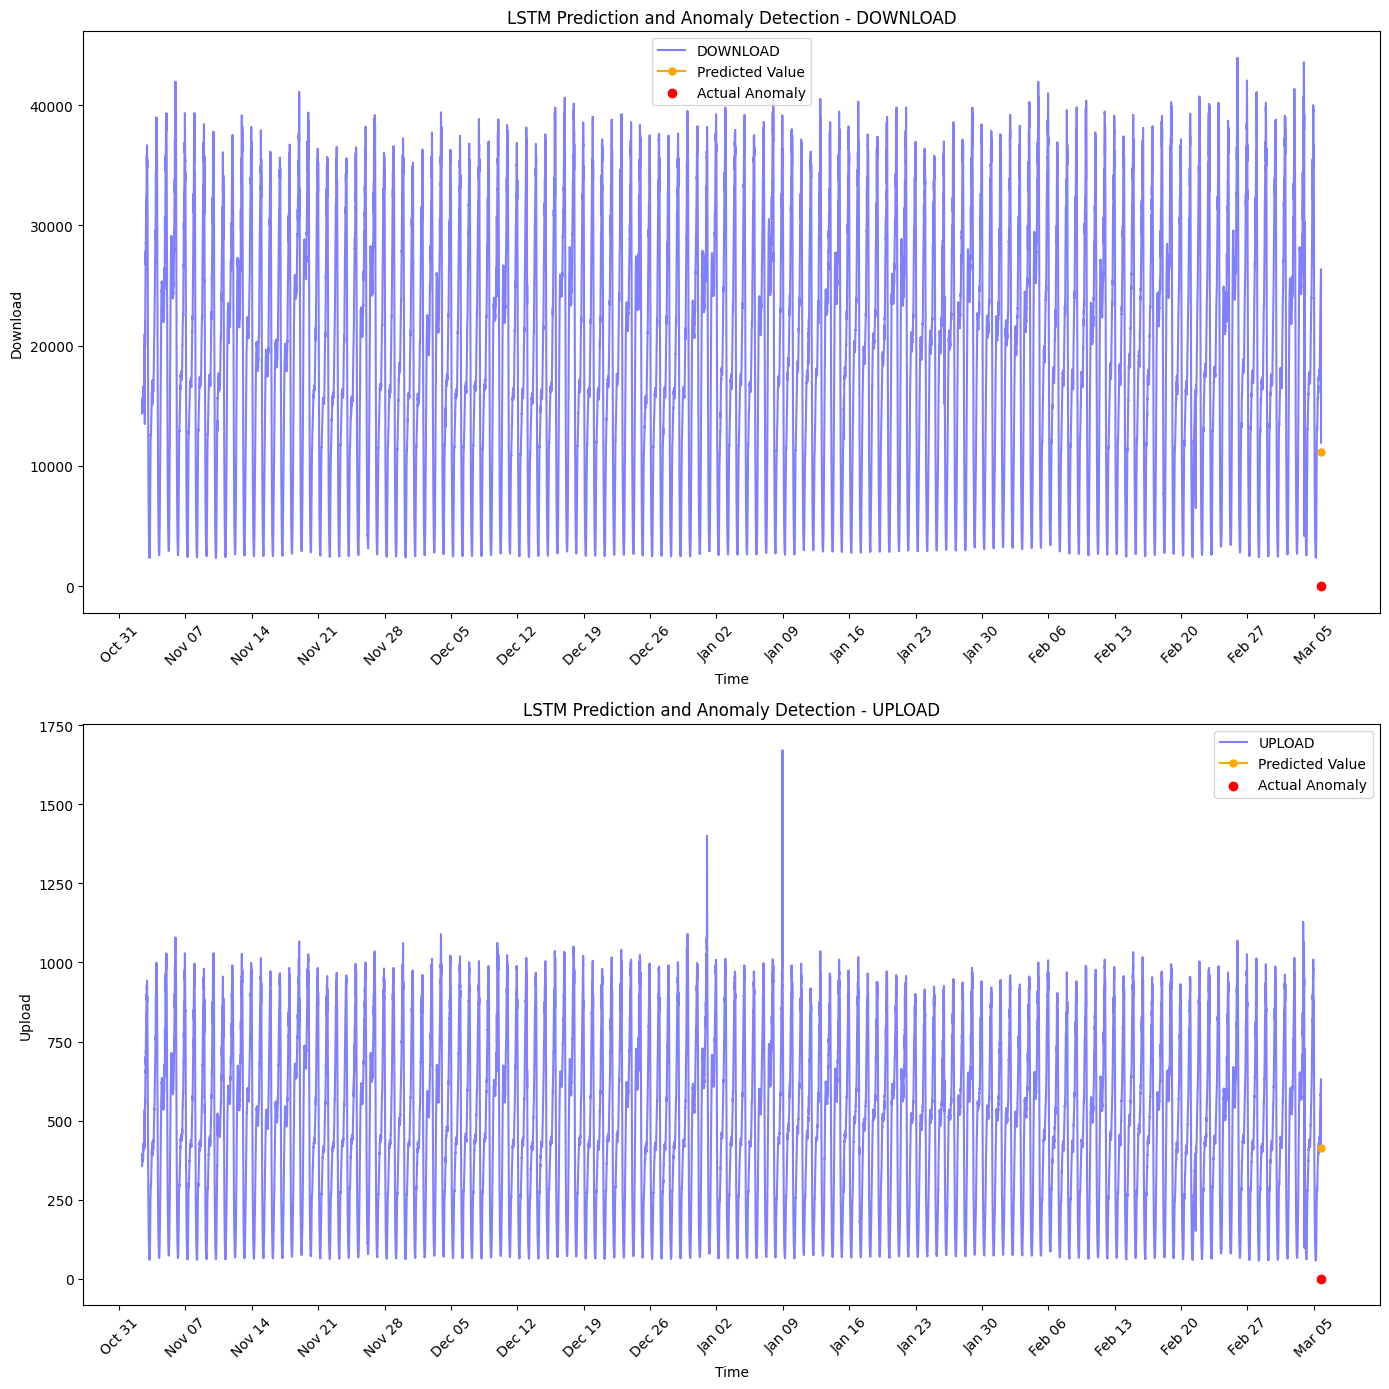

In [ ]:
# Plot the original DOWNLOAD and UPLOAD values and anomalies
fig, ax = plt.subplots(2, 1, figsize=(14, 14))

# DOWNLOAD plot
ax[0].plot(data.index, scaler_download.inverse_transform(data[['DOWNLOAD']]), label='DOWNLOAD', color='blue', alpha=0.5)
# Convert timestamp string to datetime object for plotting
ax[0].plot([pd.Timestamp(timestamp)], [predicted_download], marker='o', markersize=5, color='orange', label='Predicted Value')
if is_anomaly_download:
    ax[0].scatter(pd.Timestamp(timestamp), specific_data['DOWNLOAD'], color='red', label='Actual Anomaly')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Download')
ax[0].set_title('LSTM Prediction and Anomaly Detection - DOWNLOAD')
ax[0].legend()

# UPLOAD plot
ax[1].plot(data.index, scaler_upload.inverse_transform(data[['UPLOAD']]), label='UPLOAD', color='blue', alpha=0.5)
# Convert timestamp string to datetime object for plotting
ax[1].plot([pd.Timestamp(timestamp)], [predicted_upload], marker='o', markersize=5, color='orange', label='Predicted Value')
if is_anomaly_upload:
    ax[1].scatter(pd.Timestamp(timestamp), specific_data['UPLOAD'], color='red', label='Actual Anomaly')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Upload')
ax[1].set_title('LSTM Prediction and Anomaly Detection - UPLOAD')
ax[1].legend()

# X-axis formatting
for a in ax:
    a.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    a.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Bonus

Adım 1: Veriyi Yükleme ve Ön İşleme


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the updated Excel file
file_path = '/data_1.xlsx'
data = pd.read_excel(file_path)

# Convert TIME_STAMP to datetime
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Extract hour from TIME_STAMP
data['HOUR'] = data['TIME_STAMP'].dt.hour

# Display the first few rows of the data to inspect it
print(data.head())
print(data.info())


           TIME_STAMP           SERVER_NAME   DOWNLOAD   UPLOAD  HOUR
0 2023-11-02 10:10:00  10.0.901.xx Server 1  14611.335  357.395    10
1 2023-11-02 10:15:00  10.0.901.xx Server 1  14336.298  355.811    10
2 2023-11-02 10:20:00  10.0.901.xx Server 1  14381.373  357.816    10
3 2023-11-02 10:25:00  10.0.901.xx Server 1  14461.797  358.717    10
4 2023-11-02 10:30:00  10.0.901.xx Server 1  14604.990  364.365    10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35429 entries, 0 to 35428
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TIME_STAMP   35429 non-null  datetime64[ns]
 1   SERVER_NAME  35429 non-null  object        
 2   DOWNLOAD     35429 non-null  float64       
 3   UPLOAD       35429 non-null  float64       
 4   HOUR         35429 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(1)
memory usage: 1.2+ MB
None


Adım 2: Saatlik Trafik Verilerini Hesaplama


In [102]:
# Calculate hourly mean for DOWNLOAD and UPLOAD
hourly_traffic = data.groupby('HOUR')[['DOWNLOAD', 'UPLOAD']].mean()

# Display the calculated hourly traffic
print(hourly_traffic)


          DOWNLOAD      UPLOAD
HOUR                          
0     30503.295930  766.468710
1     19418.344192  480.727825
2     10502.802042  261.519166
3      5691.739048  143.201510
4      3440.368907   87.106335
5      2835.411435   71.272112
6      4335.491665  105.504086
7      8243.453599  192.753840
8     11416.844473  258.612816
9     14296.554776  330.465491
10    17157.112362  413.294872
11    19305.651800  476.637486
12    20145.872236  507.234622
13    19997.751545  509.649338
14    19236.356189  492.254177
15    19552.662037  497.293930
16    21155.454794  532.173788
17    22758.254996  573.940191
18    24557.196876  624.996009
19    27736.846552  707.660149
20    30539.754791  802.411190
21    32913.354761  878.126808
22    35938.868070  944.783802
23    36021.987919  921.975905


Adım 3: Grafik Çizimi

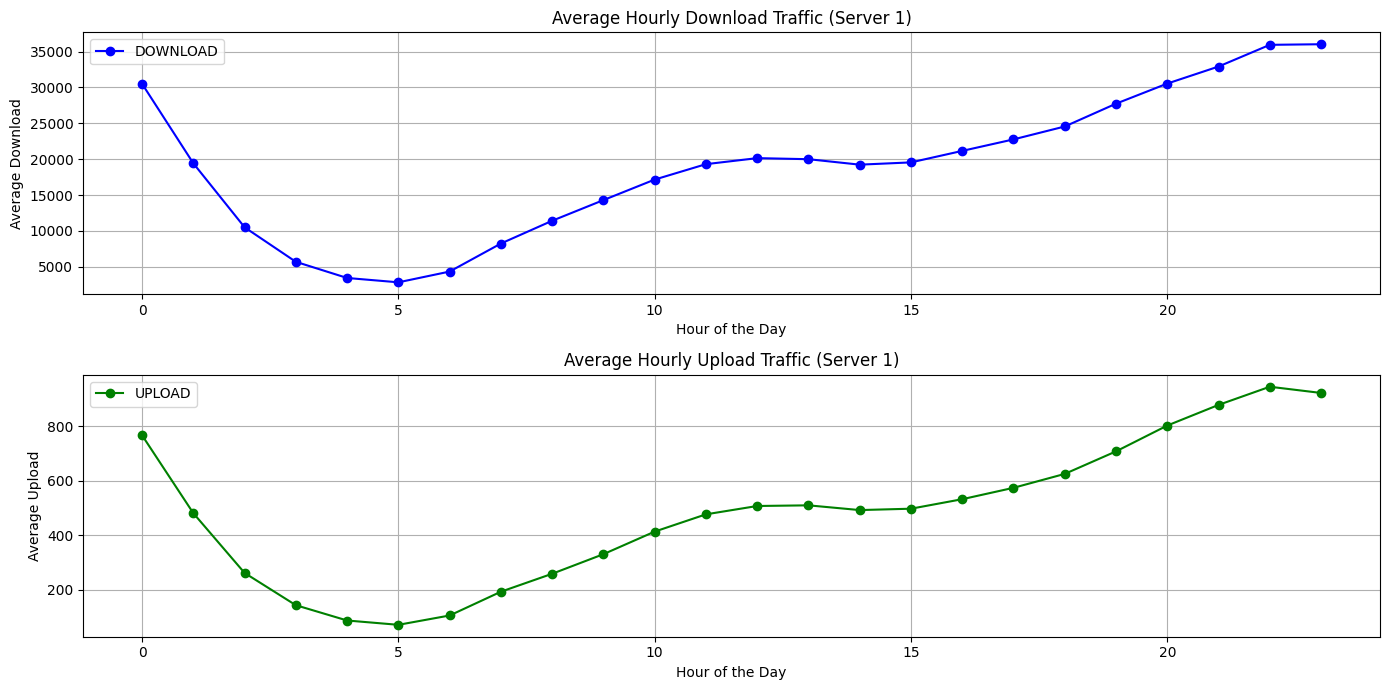

In [103]:
# Plot the hourly traffic
plt.figure(figsize=(14, 7))

# Plot for DOWNLOAD
plt.subplot(2, 1, 1)
plt.plot(hourly_traffic.index, hourly_traffic['DOWNLOAD'], marker='o', linestyle='-', color='blue', label='DOWNLOAD')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Download')
plt.title('Average Hourly Download Traffic (Server 1)')
plt.legend()
plt.grid(True)

# Plot for UPLOAD
plt.subplot(2, 1, 2)
plt.plot(hourly_traffic.index, hourly_traffic['UPLOAD'], marker='o', linestyle='-', color='green', label='UPLOAD')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Upload')
plt.title('Average Hourly Upload Traffic (Server 1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
